In [57]:
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [100]:
# constants
BATCH_SIZE = 2048
target_mean = 0.5 # for normalizing image data
target_std = 0.5 # for normalizing image data
ENCODING_SIZE = 32

## Load data

In [59]:
initial_transform = transforms.Compose([transforms.ToTensor(),])
initial_dataset = datasets.MNIST(root='./data', train=True, transform=initial_transform, download=True)
initial_loader = torch.utils.data.DataLoader(initial_dataset, batch_size=len(initial_dataset))

In [60]:
data = next(iter(initial_loader))[0] # gets the entire dataset
current_mean = data.mean().item()
current_std = data.std().item()

In [61]:
print(f"{data.shape = }")
print(f"{current_mean = }")
print(f"{current_std = }")

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.13066047430038452
current_std = 0.30810782313346863


In [62]:
transform_mean = (current_mean * target_std - target_mean * current_std) / target_std
transform_std = current_std / target_std

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((transform_mean,), (transform_std,)),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [63]:
# test statistics (make sure mean and median are 0.5 and 0.5)
statistics_test_loader = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
statistics_test_loader = torch.utils.data.DataLoader(statistics_test_loader, batch_size=len(statistics_test_loader))
data = next(iter(statistics_test_loader))[0] # gets the normalized entire dataset
current_mean = data.mean().item()
current_std = data.std().item()
print(f"{data.shape = }")
print(f"{current_mean = }") # confirm mean ~0.5
print(f"{current_std = }")  # confirm std  ~0.5

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.4999999701976776
current_std = 0.4999999701976776


## Training

In [64]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [112]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, ENCODING_SIZE)
        )
        self.decoder = nn.Sequential(
            nn.Linear(ENCODING_SIZE, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )

    def forward(self, x):
        encoding = self.encoder(x)
        # TODO: masking
        logits = self.decoder(encoding)
        return encoding, logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=False)
  )
)


In [113]:
l1_loss = nn.L1Loss()
def loss_fn(X, X_hat, encoding, lambda_term=0.003, gamma=0.1):
    # Mean absolute error for reconstruction
    mae_reconstruction = l1_loss(X, X_hat)
    
    # L1 norm for encoding
    encoding_loss = torch.norm(encoding, p=1) * lambda_term * (1/BATCH_SIZE)
    
    # Correlation scores
    encoding_avgs = encoding.sum(dim=0) / ENCODING_SIZE # this is like z_* in the paper
    # TODO: optimize this (probably don't actually need a loop here)
    correlation_scores = 0
    print("here!")
    for k in range(0, 16):
        for  h in range(16, 32):
            numerator = 0
            z_star_k = encoding_avgs[k]
            z_star_h = encoding_avgs[h]
            
            for i in range(BATCH_SIZE):
                z_i_k = encoding[i][k]
                z_i_h = encoding[i][h]
                numerator += torch.abs(z_i_k-z_star_k) + torch.abs(z_i_h-z_star_h)
            
            all_z_k = encoding[:,k]
            norm_k_term = ((torch.sum(all_z_k - z_star_k))**2)**(1/2)
            
            all_z_h = encoding[:,h]
            norm_h_term = ((torch.sum(all_z_h - z_star_k))**2)**(1/2)
            correlation_scores += numerator / (norm_k_term * norm_h_term)
    correlation_scores *= 1/(16**2) * gamma
    print(correlation_scores)

    
    return mae_reconstruction + encoding_loss + correlation_scores

In [114]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [115]:
def train(data_loader, loss, optimizer, model, epochs=1):
    model.train()
    train_loss_statistics = []
    
    for epoch in range(epochs):
        for batch_idx, data in enumerate(data_loader):
            X, y = data
            X = torch.flatten(X, start_dim=1).to(device)
            encoding, X_hat = model.forward(X)

            batch_loss = loss(X, X_hat, encoding)
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_statistics.append(batch_loss.item())

            if batch_idx % 10 == 0:
                print(f"batch #{len(data_loader)*epoch + batch_idx}: {batch_loss}")
                
    return train_loss_statistics

In [ ]:
train_loss_statistics = train(train_loader, loss_fn, optimizer, model, epochs=1)

here!
tensor(0.0020, device='mps:0', grad_fn=<MulBackward0>)


In [102]:
# 0.06390269100666046

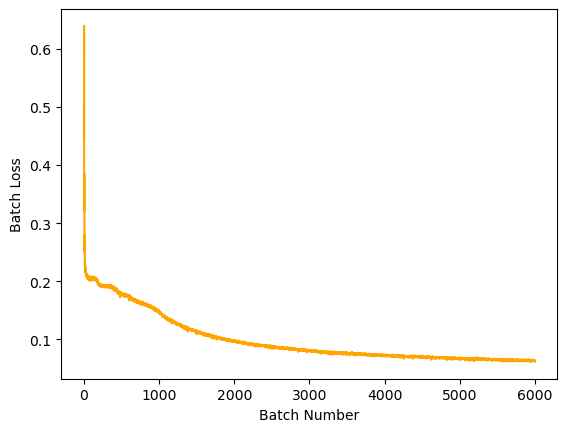

In [70]:
plt.plot(np.arange(0, len(train_loss_statistics)), train_loss_statistics, color='orange')
plt.xlabel("Batch Number")
plt.ylabel("Batch Loss")
plt.show()

## Saving Model

In [89]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 200,
    'loss': 0.06390269100666046
}, "200_epochs_no_correlation_loss/model.pth")

## Generating Image Samples

In [81]:
test_images_batch = next(iter(test_loader))[0]

In [82]:
# get reconstructed images
_encodings, reconstructed_test_imgs = model.forward(torch.flatten(test_images_batch, start_dim=1).to("mps"))
reconstructed_test_imgs = reconstructed_test_imgs.view(-1, 28, 28)
reconstructed_test_imgs= reconstructed_test_imgs.cpu().detach()

In [93]:
_encodings.shape

torch.Size([2048, 32])

In [99]:
_encodings.sum(dim=0).shape

torch.Size([32])

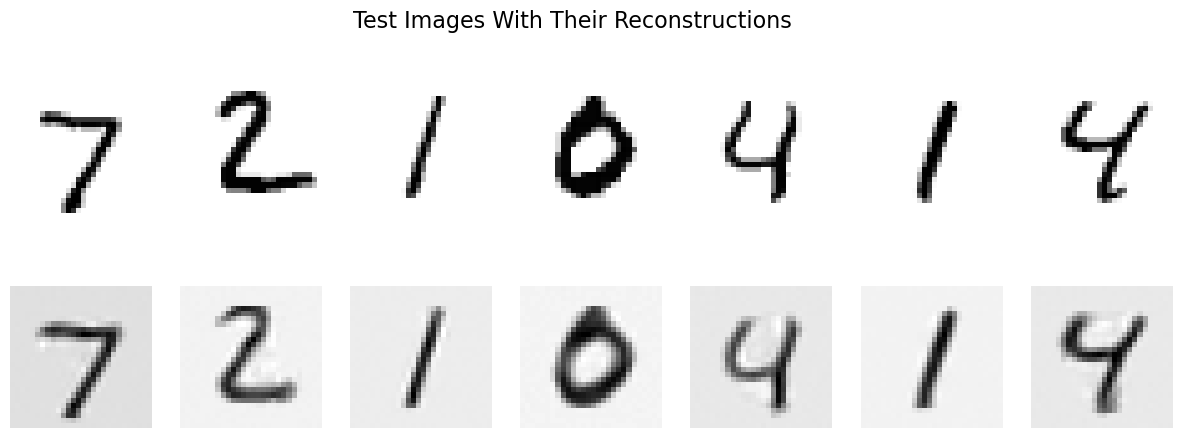

In [91]:
columns = 7
rows = 2
fig, axes = plt.subplots(rows, columns, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    if i >= columns:
        ax.imshow(reconstructed_test_imgs[i - columns]* -1, cmap='gray')
    else:
        ax.imshow(test_images_batch[i].squeeze()* -1, cmap='gray')
    ax.axis('off')
fig.suptitle('Test Images With Their Reconstructions', fontsize=16)
plt.savefig('200_epochs_no_correlation_loss/image_reconstructions.png', dpi=300)
plt.show()